### Load and Prepare Data

In [16]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Load in data: df
df = pd.read_csv('https://s3.amazonaws.com/clcarverloans/data/df_cleaned.csv')

In [18]:
# Remove usesless rows: df_select
cols = ['Borrower_Genders', 'Country Code', 'Loan Amount', 'Lender_Term',
       'Repayment_Interval', 'Distribution_Model', 'Sector', 'Activity','Delinquent']
df_select = df[cols]

# One_hot_encode categorical columns: df_dummies
df_dummies = pd.get_dummies(df_select)

# Select features and target: X, y
y = df_dummies.pop('Delinquent')
X = df_dummies

In [19]:
# Split data into train and test set: X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create Trade-off Metric

First off, we should know what the average principal per loan is

In [20]:
average_loan_amount = df['Loan Amount'].mean()
print('Average Loan Size is: $', average_loan_amount)

Average Loan Size is: $ 770.9566877046869


Next, we should know average interest rate of the loan. According to Kiva's Q&A section the field partners charge around 36%

In [21]:
average_interest_rate = 0.36
print('Average Interest Rate: {}%'.format(int(average_interest_rate*100)))

Average Interest Rate: 36%


In [22]:
average_profit = average_loan_amount * average_interest_rate
print('Average Profit Per Loan: $', average_profit)

Average Profit Per Loan: $ 277.5444075736873


This means, on average, the banks make around $278 dollars per loan. The resulting cost benefit matrix would look like so:

TP = 0, FP = -278, FN = -770, TN = +278

### Create Functions to Create Profit Curve

In [62]:
labels = np.array([1,0,0,1])
predicted_probs = np.array([0.8,0.3,0.2,0.5])
# Sort the probabilities: sorted_probs
sorted_probs = np.sort(predicted_probs)

In [75]:
for i in range(len(sorted_probs)):
        print((sorted_probs >= sorted_probs[i]) == labels)
        print(sorted_probs)

[ True False False  True]
[0.2 0.3 0.5 0.8]
[False False False  True]
[0.2 0.3 0.5 0.8]
[False  True False  True]
[0.2 0.3 0.5 0.8]
[False  True  True  True]
[0.2 0.3 0.5 0.8]


In [34]:
from sklearn.metrics import confusion_matrix

# Create a function that returns an array of the profits at each threshold: profit_curve
def profit_curve(cost_benefit, predicted_probs, labels):
    
    # Sort the probabilities: sorted_probs
    sorted_probs = np.sort(predicted_probs)
    
    # Make predictions at each threshold level: y_predictions
    y_predictions = [] # List of a list of predictions
    for threshold in sorted_probs:
        (sorted_probs >= sorted_probs[threshold]) == y_true # Set the current probability to the threshold
        
        # Check each probability in sorted_probs against the threshold and create a list of predictions: y_pred
        y_pred = []
        for prob in sorted_probs:
            if prob > threshold:
                y_pred.append(1) 
            else:
                y_pred.append(0)
        y_predictions.append(y_pred)
              
    # Calculate profit for each confusion matrix: profit_list
    profit_list = []
    for y_pred in y_predictions:
        conf_matrix = confusion_matrix(labels, y_pred)
        value_matrix = np.dot(conf_matrix, cost_benefit)
        profit_list.append(np.sum(value_matrix)/(len(labels)))  # Profit at single threshold added to profit_list  
    
    # Return an array of the profits at each threshold
    return profit_list

In [59]:
(y_pred >= y_pred[1]) == y_true

array([ True, False,  True, False])

In [35]:
# Build a function that plots our profit curve: plot_profit_curve
def plot_profit_curve(model, cost_benefit, X_train, X_test, y_train, y_test):
    md = model
    md.fit(X_train, y_train)
    probs = md.predict_proba(X_test)[:,1]
    profits = profit_curve(cost_benefit, probs, y_test)
    percentages = np.arange(0, 100, 100. / len(profits))
    ax = plt.plot(percentages, profits)
    plt.title("Profit Curve")
    plt.ylabel("Profit")
    plt.show()

In [52]:
cost_benefit_matrix = np.array([[average_profit, -average_profit], [-average_loan_amount, 0]])

In [53]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(class_weight={0:1, 1:24})

No handles with labels found to put in legend.


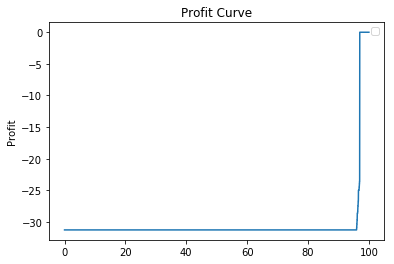

In [54]:
plot_profit_curve(dt, cost_benefit_matrix, X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.metrics import roc_curve
tpr, fpr, th

___

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score

# Create a function that returns an array of the number of borrowers blocked at each threshold: trade_off_curve
def trade_off_curve(predicted_probs, labels):
    
    # Sort the probabilities: sorted_probs
    sorted_probs = np.sort(predicted_probs)
    
    # Make predictions at each threshold level: y_predictions
    y_predictions = [] # List of a list of predictions
    for prob in sorted_probs:
        threshold = prob # Set the current probability to the threshold
        
        # Check each probability in sorted_probs against the threshold and create a list of predictions: y_pred
        y_pred = []
        for prob in sorted_probs:
            if prob > threshold:
                y_pred.append(1) 
            else:
                y_pred.append(0)
        y_predictions.append(y_pred)
              
    # Calculate profit for each confusion matrix: profit_list
    recall_list = []
    specificity_list = []
    for y_pred in y_predictions:
        recall = recall_score(labels, y_pred) # Compute recall
        conf_matrix = confusion_matrix(labels, y_pred) # Create confusion matrix to calculate specificity (TNR)
        specificity = confusion_matrix
        profit_list.append(np.sum(value_matrix)/(len(labels)))  # Profit at single threshold added to profit_list  
    
    # Return an array of the profits at each threshold
    return profit_list